In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation, causal_mask
import os

In [19]:
from get_accuracy import *
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [17]:
def beam_search_decode(model, beam_size, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_initial_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    # Create a candidate list
    candidates = [(decoder_initial_input, 1)]

    while True:

        # If a candidate has reached the maximum length, it means we have run the decoding for at least max_len iterations, so stop the search
        if any([cand.size(1) == max_len for cand, _ in candidates]):
            break

        # Create a new list of candidates
        new_candidates = []

        for candidate, score in candidates:

            # Do not expand candidates that have reached the eos token
            if candidate[0][-1].item() == eos_idx:
                continue

            # Build the candidate's mask
            candidate_mask = causal_mask(candidate.size(1)).type_as(source_mask).to(device)
            # calculate output
            out = model.decode(encoder_output, source_mask, candidate, candidate_mask)
            # get next token probabilities
            prob = model.project(out[:, -1])
            # get the top k candidates
            topk_prob, topk_idx = torch.topk(prob, beam_size, dim=1)
            for i in range(beam_size):
                # for each of the top k candidates, get the token and its probability
                token = topk_idx[0][i].unsqueeze(0).unsqueeze(0)
                token_prob = topk_prob[0][i].item()
                # create a new candidate by appending the token to the current candidate
                new_candidate = torch.cat([candidate, token], dim=1)
                # We sum the log probabilities because the probabilities are in log space
                new_candidates.append((new_candidate, score + token_prob))

        # Sort the new candidates by their score
        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)
        # Keep only the top k candidates
        candidates = candidates[:beam_size]

        # If all the candidates have reached the eos token, stop
        if all([cand[0][-1].item() == eos_idx for cand, _ in candidates]):
            break

    # Return the best candidate
    return candidates[0][0].squeeze()

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=2, plot=False, print_text=False):
    model.eval()
    count = 0
    cc_init = []
    cc_beam = []
    cc_greedy = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in tqdm(validation_ds):
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            
            model_out_greedy = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            model_out_beam = beam_search_decode(model, 3, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text_beam = tokenizer_tgt.decode(model_out_beam.detach().cpu().numpy())
            model_out_text_greedy = tokenizer_tgt.decode(model_out_greedy.detach().cpu().numpy())
            

            # get accuracy
            c_init, _, _ = get_accuracy(target_text, source_text, plot=plot)
            cc_init.append(c_init)
            c_greedy, _, _ = get_accuracy(target_text, model_out_text_greedy, plot=plot)
            cc_greedy.append(c_greedy)
            c_beam, _, _ = get_accuracy(target_text, model_out_text_beam, plot=plot)
            cc_beam.append(c_beam)
            
            # Print the source, target and model output
            if print_text:
                print_msg('-'*console_width)
                print_msg(f"{f'SOURCE: ':>20}{source_text}")
                print_msg(f"{f'TARGET: ':>20}{target_text}")
                print_msg(f"{f'PREDICTED GREEDY: ':>20}{model_out_text_greedy}")
                print_msg(f"{f'PREDICTED BEAM: ':>20}{model_out_text_beam}")
                print_msg(f"{f'CC init: ':>12}{c_init:.3f}")
                print_msg(f"{f'CC greedy: ':>12}{c_greedy:.3f}")
                print_msg(f"{f'CC beam: ':>12}{c_beam:.3f}")

            
            if count == num_examples:
                print_msg('-'*console_width)
                plt.figure()
                sns.violinplot(data=[cc_init,cc_greedy,cc_beam])
                plt.xticks(ticks = [0, 1, 2], labels = ['init','greedy', 'beam'], fontsize = 11)
                plt.show()
                plt.close()

                plt.figure()
                plt.bar(['init', 'greedy', 'beam'], [np.mean(cc_init), np.mean(cc_greedy), np.mean(cc_beam)])
                plt.show()
                plt.close()
                
                plt.figure()
                plt.scatter(cc_init, cc_greedy)
                plt.xlabel('init')
                plt.ylabel('greedy prediction')
                x = np.linspace(min(cc_init), max(cc_greedy), 100)
                plt.plot(x,x, '-r', label='y=x')
                plt.show()
                plt.close()
                
                break


In [4]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
config = get_config()
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"99")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

Using device: cuda
Max length of source sentence: 100
Max length of target sentence: 100


<All keys matched successfully>

stty: 'standard input': Inappropriate ioctl for device
  1%|          | 99/10000 [01:23<2:18:41,  1.19it/s]

--------------------------------------------------------------------------------


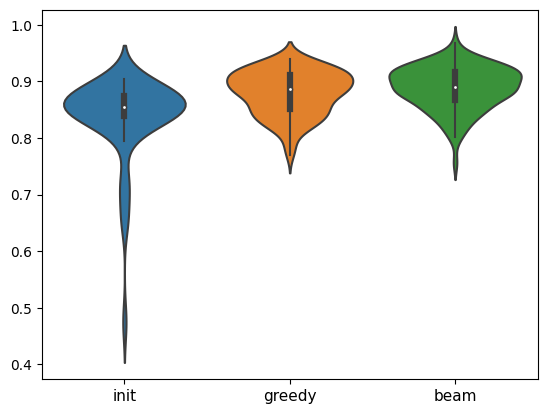

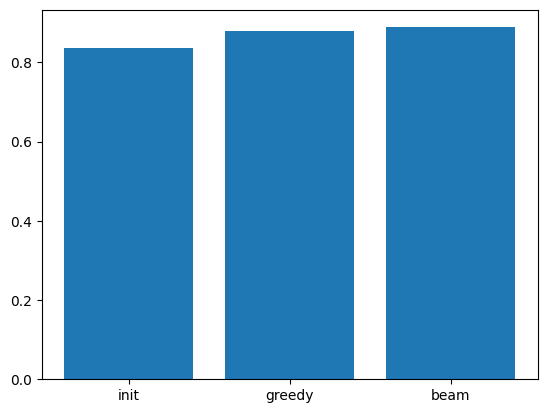

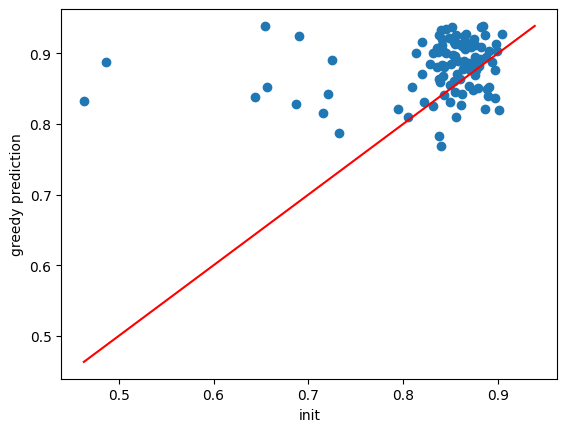

  1%|          | 99/10000 [01:24<2:20:32,  1.17it/s]


: 

In [21]:
plot=False
print_text=False
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, print_msg=print, num_examples=100, plot=plot, print_text=print_text)